# Kunskapskontroll Deep Learning - Matilda Wilhelmsson DS23
# Classifiers Age, Ethnicity and Gender

### Abstract
In the code down below I create 3 different CNNs focusing independently on identifying age, ethnicity and gender
in photographs of different people. The first model focuses on age and ended up having a validation error of around 8 years.
The second model focuses on ethnicity and have a validation accuracy of 74%. 
The third model focuses on gender and have a validation accuracy of 86%.
These models will be used as classifiers in a camera module.

### References
The code was borrowed from the link below. 
I have made adaptions and extensions to the original code.
https://www.kaggle.com/code/moathmohamed/facial-classification-prediction-with-cnns/notebook

### Importing necessary libraries and looking at the data

In [124]:
# First I start with importing all necessary libraries so we can execute our code without errors.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import warnings 
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Here I check for any GPUs available on the computer to make sure I can process the code fast enough.
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [125]:
# Here I load the dataset that we will use to train and test the model.
# We also take a look at five of the data entries to get a grasp of the data structure.
df = pd.read_csv("C:/Users/Matil/ec_utbildning/ds23_deep_learning/age_gender.csv/age_gender.csv")
df = shuffle(df)
df.head()


,age,ethnicity,gender,img_name,pixels
6229,26,2,1,20170116175511254.jpg.chip.jpg,78 90 87 76 60 47 48 76 120 148 167 178 185 19...
22555,78,2,0,20170112222045626.jpg.chip.jpg,196 198 187 180 161 127 122 135 149 153 152 15...
5195,24,2,1,20170112204451203.jpg.chip.jpg,122 124 123 122 123 53 13 7 14 11 11 11 11 12 ...
206,1,4,0,20170103202334544.jpg.chip.jpg,140 146 152 158 161 164 170 176 182 190 197 20...
12200,32,2,0,20170116190057472.jpg.chip.jpg,6 6 6 6 6 6 4 5 7 9 9 9 11 12 12 12 12 13 11 1...


In [126]:
# I check the dimensions of the pictures in the dataset. This is important to know later on when we need to specify the input_shape in the model.
num_pixels = len(df['pixels'][0].split(" "))
img_height = int(np.sqrt(len(df['pixels'][0].split(" "))))
img_width = int(np.sqrt(len(df['pixels'][0].split(" "))))
print(num_pixels, img_height, img_width)

2304 48 48


In [127]:
# We convert the pixels to numerical float-values in order to use these in numerical operations.
df['pixels'] = df['pixels'].apply(lambda x: np.array(x.split(),dtype='float32'))

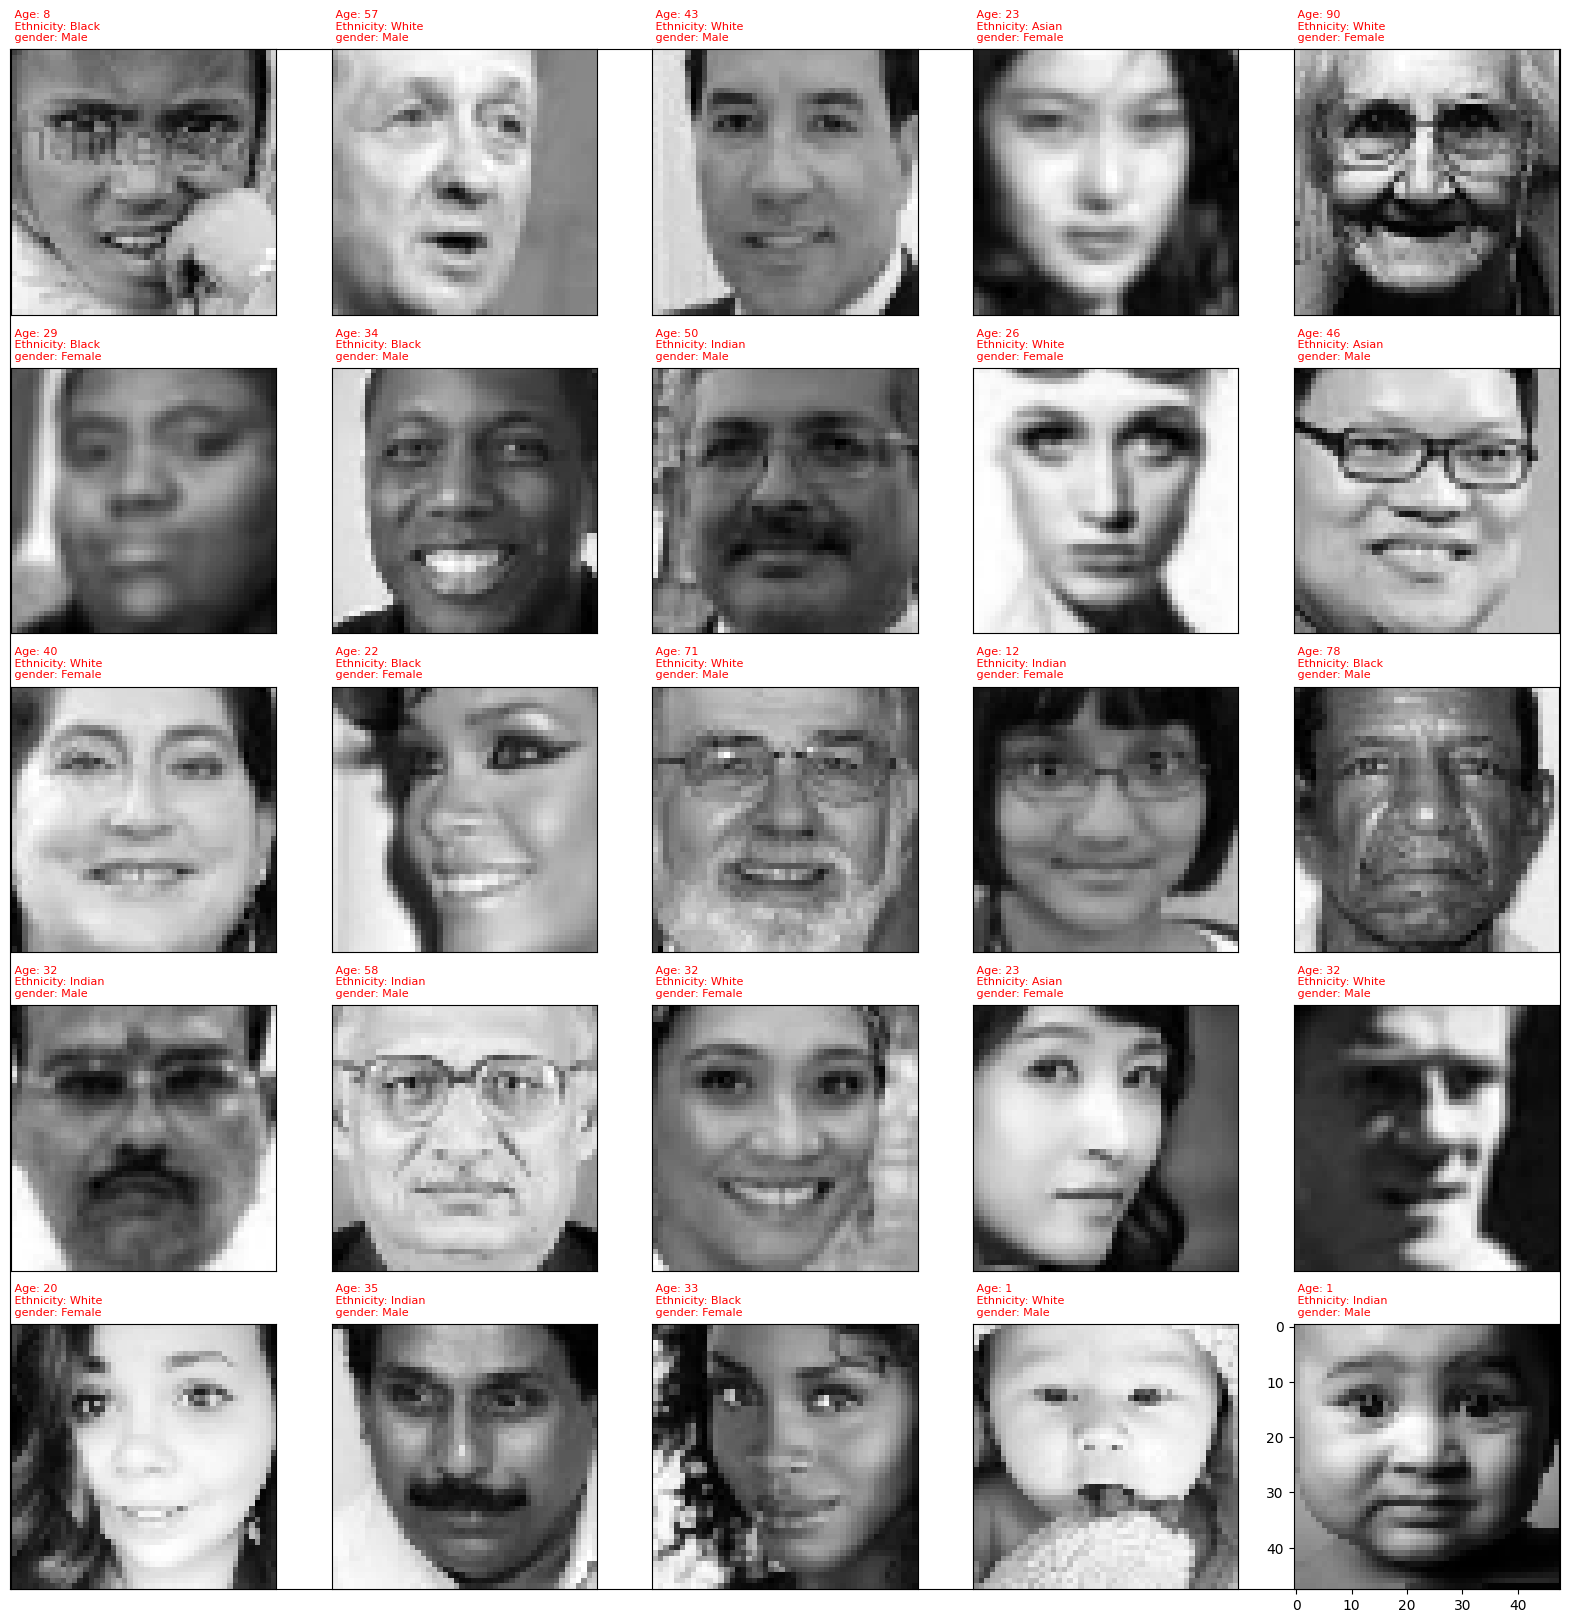

In [128]:
# I do a deeper check on the data. Showing the pictures with their respective labels.
# This helps us check wether the data seems reliable and correct.
plt.figure(figsize=(20, 20))

for i in range(25):  
    index = np.random.randint(0, len(df))
    plt.xticks([])
    plt.yticks([])   
    plt.grid(False)
    plt.subplot(5, 5, i+1)
    plt.imshow(df['pixels'].iloc[index].reshape(48, 48),"gray")
    plt.title(' Age: {}\n Ethnicity: {}\n gender: {}'.format(df['age'].iloc[index], {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Hispanic"}[df['ethnicity'].iloc[index]], {0:"Male", 1:"Female"}[df['gender'].iloc[index]]),loc="left",color='red',fontsize = 8)

plt.show()

### Model - age

In [129]:
# We start splitting the dataset into X and y(using the 'age' labels).
X = np.array(df['pixels'].tolist())
X = np.reshape(X, (-1, 48, 48,1))
y = df['age']

# We then split the dataset into a trainset and a testset. The testset is used to validate the training error.
# This helps us get a feeling for how well the modell will perform on new data it hasn't been trained on.
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X, y, test_size=0.3, random_state=44)

In [130]:

# We normalize the pixels values in the trainingset and testset(ranging from 0 to 255 so that it instead ranges from 0 to 1).
# This helps with computing and training the model.
# We specify the batch_size to be 32. This is a hyperparameter that has been tuned to find the best size.
train_datagen=ImageDataGenerator(rescale=1/255)
train_generator_age=train_datagen.flow(
    X_train_age ,y_train_age ,batch_size=32
)

test_datagen=ImageDataGenerator(rescale=1/255)
test_generator_age=test_datagen.flow(
    X_test_age ,y_test_age ,batch_size=32
)

In [131]:
# We instantiate EarlyStopping to make sure the model stops training after finding the best parameters.
earlystop=EarlyStopping(patience=3, verbose=1)

# We instantiate learning_rate_reduction that makes sure we slow down learning rate when the validation accuracy slows down improving.
# We do this because we want to settle on the best parameter values.
learning_rate_reduction=ReduceLROnPlateau(
    monitor='val_acc',
    patience= 3,
    verbose=1,
)
callbacks = [earlystop, learning_rate_reduction]

In [132]:
# We create a Convolutional neural network consisting of:
# 4 convolutional layers with pooling to identify patterns in the pictures
# 2 dropuout instances in order to reduce the interdependency between neurons
# 1 flatten layer to reshape the data for the output layer
# 1 dense output-layer 
model_age = Sequential()

model_age.add(Conv2D(32,(3,3),activation='relu',input_shape=(48,48,1)))
model_age.add(MaxPooling2D(2,2))

model_age.add(Conv2D(64,(3,3),activation='relu'))
model_age.add(MaxPooling2D(2,2))

model_age.add(Conv2D(64,(3,3),activation='relu'))
model_age.add(MaxPooling2D(2,2))
model_age.add(Dropout(0.2))

model_age.add(Conv2D(128,(3,3),activation='relu'))
model_age.add(MaxPooling2D(2,2))
model_age.add(Dropout(0.2))          
          
model_age.add(Flatten())
model_age.add(Dropout(0.5))            

model_age.add(Dense(1,activation='relu'))

# We compile the model using the adam-optimizer, loss as the mean_squared_error(because we are expecting a single number as output) and metrics as mean absolute error(mae).
# With loss and metrics we can follow the training process and analyse how the model is performing.
model_age.compile(optimizer='adam' ,loss='mean_squared_error',metrics=['mae'])

# We print out the model summary to get an overview of the model we created.
model_age.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_77 (Conv2D)          (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 4, 4, 64)       

In [133]:
# We start training the model on the trainingset and at the end of every epoch we validate the perfomance with the testset.
# We set the number of epochs to 40. This is a hyperparameter that has been tuned to find an optimal value.
model_age.fit(
    train_generator_age, 
    epochs= 40,
    validation_data= test_generator_age,
    callbacks= callbacks
)

Epoch 1/40
519/519 [==============================] - 8s 12ms/step - loss: 442.9914 - mae: 16.1722 - val_loss: 355.5348 - val_mae: 14.8621 - lr: 0.0010
Epoch 2/40
519/519 [==============================] - 5s 9ms/step - loss: 375.8230 - mae: 14.9517 - val_loss: 339.3335 - val_mae: 13.5443 - lr: 0.0010
Epoch 3/40
519/519 [==============================] - 5s 9ms/step - loss: 321.5585 - mae: 13.8289 - val_loss: 270.7709 - val_mae: 12.2293 - lr: 0.0010
Epoch 4/40
519/519 [==============================] - 4s 8ms/step - loss: 279.2329 - mae: 12.8379 - val_loss: 254.3934 - val_mae: 12.9746 - lr: 0.0010
Epoch 5/40
519/519 [==============================] - 5s 9ms/step - loss: 260.8659 - mae: 12.3246 - val_loss: 234.9766 - val_mae: 12.3514 - lr: 0.0010
Epoch 6/40
519/519 [==============================] - 4s 8ms/step - loss: 242.6032 - mae: 11.8543 - val_loss: 191.4717 - val_mae: 10.4582 - lr: 0.0010
Epoch 7/40
519/519 [==============================] - 4s 9ms/step - loss: 225.8673 - mae: 11.

In [134]:
# After training we save the model so that we can use it later.
model_age.save('age.h5')

<Axes: title={'center': 'Age'}>

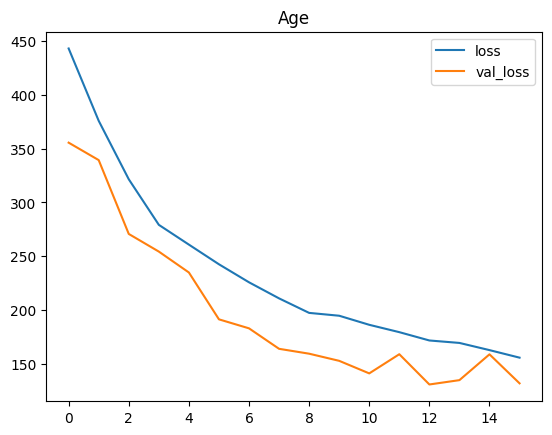

In [135]:
# We take a quick look at the loss and validation loss during the training.
# We can see that they follow each other closely.
# The validation loss stops decreasing after around 10 epochs, meaning that we have reached the optima.
losses_age = pd.DataFrame(model_age.history.history)
losses_age[['loss','val_loss']].plot(title='Age')

### Model - ethnicity

In [136]:
# We use the same X as in previous model.
# We change our y to using the ethnicity label since we are training the model on ethnicity.
y = df['ethnicity']

# We split the data into train and test.
X_train_ethnicity, X_test_ethnicity, y_train_ethnicity, y_test_ethnicity = train_test_split(X, y, test_size=0.3, random_state=44)

In [137]:
# We specify the batch_size to be 128. This is a hyperparameter that has been tuned to find the best size.
train_generator_ethnicity =train_datagen.flow(
    X_train_ethnicity ,y_train_ethnicity ,batch_size=128
)

test_generator_ethnicity =test_datagen.flow(
    X_test_ethnicity ,y_test_ethnicity ,batch_size=128
)

In [138]:
# We create a Convolutional neural network consisting of:
# 3 convolutional layers with pooling to identify patterns in the pictures
# 1 flatten layer to reshape the data for the output layer
# 1 dense layer
# 1 dense output-layer 

model_ethnicity = Sequential()

model_ethnicity.add(Conv2D(16,(3,3), padding='same',activation='relu',input_shape=(48,48,1)))
model_ethnicity.add(MaxPooling2D(2,2))

model_ethnicity.add(Conv2D(32,(3,3), padding='same',activation='relu'))
model_ethnicity.add(MaxPooling2D(2,2))

model_ethnicity.add(Conv2D(64,(3,3), padding='same',activation='relu'))
model_ethnicity.add(MaxPooling2D(2,2))

model_ethnicity.add(Flatten())
model_ethnicity.add(Dense(128,activation='relu'))

model_ethnicity.add(Dense(5,activation='softmax'))

# We compile the model using the adam-optimizer, loss as the sparse_categorical_crossentropy (because the output will be several classes) and metrics as accuracy.
# With loss and metrics we can follow the training process and analyse how the model is performing.
model_ethnicity.compile(optimizer='adam' ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# We print out the model summary to get an overview of the model we created.
model_ethnicity.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_79 (Conv2D)          (None, 48, 48, 16)        160       
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 24, 24, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_80 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_81 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 6, 6, 64)       

In [139]:
# We start training the model on the trainingset and at the end of every epoch we validate the perfomance with the testset.
# We set the number of epochs to 40. This is a hyperparameter that has been tuned to find an optimal value.
model_ethnicity.fit(
    train_generator_ethnicity, 
    epochs= 40,
    validation_data= test_generator_ethnicity,
    callbacks= callbacks
)

Epoch 1/40
130/130 [==============================] - 3s 14ms/step - loss: 1.2902 - accuracy: 0.4901 - val_loss: 1.0878 - val_accuracy: 0.5727 - lr: 0.0010
Epoch 2/40
130/130 [==============================] - 2s 12ms/step - loss: 0.9637 - accuracy: 0.6480 - val_loss: 0.9091 - val_accuracy: 0.6731 - lr: 0.0010
Epoch 3/40
130/130 [==============================] - 2s 14ms/step - loss: 0.8386 - accuracy: 0.7049 - val_loss: 0.8021 - val_accuracy: 0.7177 - lr: 0.0010
Epoch 4/40
130/130 [==============================] - 2s 12ms/step - loss: 0.7595 - accuracy: 0.7389 - val_loss: 0.7889 - val_accuracy: 0.7144 - lr: 0.0010
Epoch 5/40
130/130 [==============================] - 1s 10ms/step - loss: 0.7083 - accuracy: 0.7529 - val_loss: 0.7356 - val_accuracy: 0.7404 - lr: 0.0010
Epoch 6/40
130/130 [==============================] - 1s 9ms/step - loss: 0.6672 - accuracy: 0.7677 - val_loss: 0.6891 - val_accuracy: 0.7545 - lr: 0.0010
Epoch 7/40
130/130 [==============================] - 1s 10ms/ste

In [140]:
# After training we save the model so that we can use it later.
model_ethnicity.save('ethnicity.h5')

<Axes: title={'center': 'Ethnicity'}>

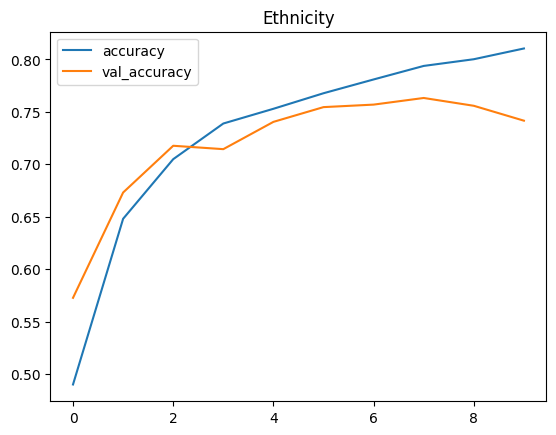

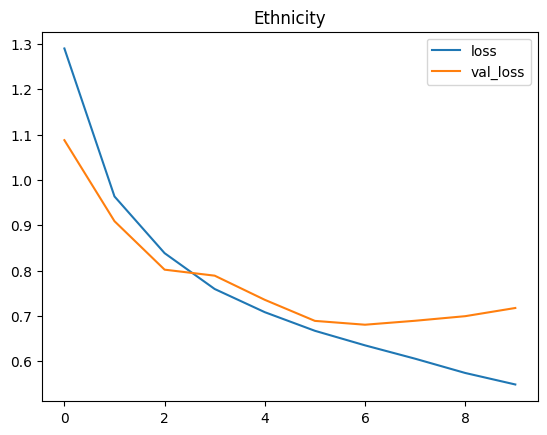

In [141]:
# We take a quick look at the accuracy and validation accuracy during the training.
# We can see that they follow each other closely.
# The validation accuracy stops increasing after around 6/7 epochs, meaning that we have reached the optima.
losses_ethnicity = pd.DataFrame(model_ethnicity.history.history)
losses_ethnicity[['accuracy','val_accuracy']].plot(title='Ethnicity')
losses_ethnicity[['loss','val_loss']].plot(title='Ethnicity')

### Model - gender

In [142]:
# We use the same X as in previous models.
# We change our y to using the gender label since we are training the model on gender.
y = df['gender']

# We split the data into test and train.
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(X, y, test_size=0.3, random_state=44)

In [143]:
# We specify the batch_size to be 32. This is a hyperparameter that has been tuned to find the best size.
train_generator_gender =train_datagen.flow(
    X_train_gender ,y_train_gender ,batch_size=32
)

test_generator_gender =test_datagen.flow(
    X_test_gender ,y_test_gender ,batch_size=32
)

In [144]:
# We create a Convolutional neural network consisting of:
# 3 convolutional layers with pooling to identify patterns in the pictures
# 1 flatten layer to reshape the data for the output layer
# 1 dense output-layer 
model_gender = Sequential()

model_gender.add(Conv2D(32,(3,3),activation='relu',input_shape=(48,48,1)))
model_gender.add(MaxPooling2D(2,2))

model_gender.add(Conv2D(64,(3,3),activation='relu'))
model_gender.add(MaxPooling2D(2,2))

model_gender.add(Conv2D(64,(3,3),activation='relu'))
model_gender.add(MaxPooling2D(2,2))

model_gender.add(Flatten())
model_gender.add(Dense(1,activation='sigmoid'))

# We compile the model using the SGD-optimizer, loss as the BinaryCrossentropy (because the output will be 2 classes) and metrics as accuracy.
# With loss and metrics we can follow the training process and analyse how the model is performing.
model_gender.compile(optimizer='SGD' ,loss='BinaryCrossentropy',metrics=['accuracy'])

# We print out the model summary to get an overview of the model we created.
model_gender.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_82 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_83 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_83 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_84 (Conv2D)          (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 4, 4, 64)       

In [145]:
# We start training the model on the trainingset and at the end of every epoch we validate the perfomance with the testset.
# We set the number of epochs to 40. This is a hyperparameter that has been tuned to find an optimal value.
model_gender.fit(
    train_generator_gender, 
    epochs= 40,
    validation_data= test_generator_gender,
    callbacks= callbacks
)

Epoch 1/40
519/519 [==============================] - 6s 10ms/step - loss: 0.6895 - accuracy: 0.5466 - val_loss: 0.6852 - val_accuracy: 0.5494 - lr: 0.0100
Epoch 2/40
519/519 [==============================] - 5s 9ms/step - loss: 0.6763 - accuracy: 0.5983 - val_loss: 0.6665 - val_accuracy: 0.6448 - lr: 0.0100
Epoch 3/40
519/519 [==============================] - 4s 8ms/step - loss: 0.6436 - accuracy: 0.6525 - val_loss: 0.6243 - val_accuracy: 0.6569 - lr: 0.0100
Epoch 4/40
519/519 [==============================] - 4s 7ms/step - loss: 0.6016 - accuracy: 0.6837 - val_loss: 0.6133 - val_accuracy: 0.6510 - lr: 0.0100
Epoch 5/40
519/519 [==============================] - 4s 7ms/step - loss: 0.5688 - accuracy: 0.7099 - val_loss: 0.5690 - val_accuracy: 0.7009 - lr: 0.0100
Epoch 6/40
519/519 [==============================] - 4s 7ms/step - loss: 0.5286 - accuracy: 0.7431 - val_loss: 0.5043 - val_accuracy: 0.7645 - lr: 0.0100
Epoch 7/40
519/519 [==============================] - 4s 7ms/step - l

In [146]:
# After training we save the model so that we can use it later.
model_gender.save('gender.h5')

<Axes: title={'center': 'Gender'}>

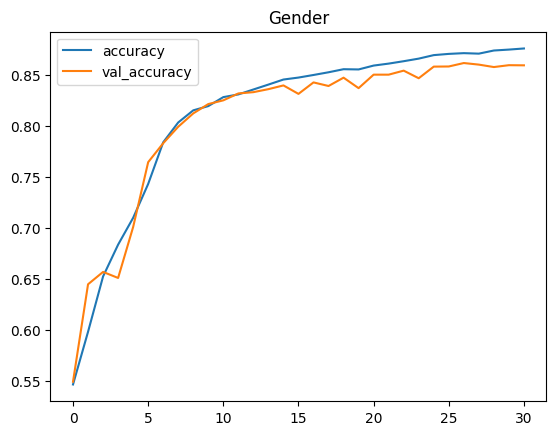

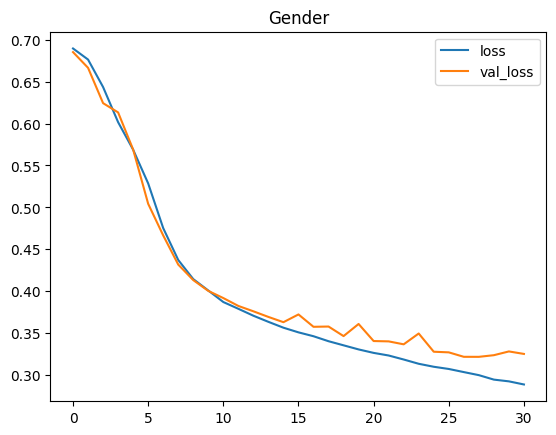

In [147]:
# We take a quick look at the accuracy and validation accuracy during the training.
# We can see that they follow each other closely.
# The validation accuracy stops increasing after around 25 epochs, meaning that we have reached the optima.
losses_gender = pd.DataFrame(model_gender.history.history)
losses_gender[['accuracy','val_accuracy']].plot(title='Gender')
losses_gender[['loss','val_loss']].plot(title='Gender')